In [1]:
# Import Modules
import numpy as np 
import pyprimes
import matplotlib.pyplot as plt 
import seaborn as sns

# Import Functions
from mpmath import zeta
from scipy.stats import gumbel_r, linregress, norm 
from scipy.interpolate import interp1d
from time import time 

In [2]:
# Loading in Cython (C wrapper)
%load_ext Cython

## <h1><center> NUMERICAL STUDY OF THE LARGE VALUES OF THE RIEMANN ZETA FUNCTION SUPERVISED BY PROF. L.P. ARGUIN </center></h1>

**Objectives The goal is to develop numerical methods to verify and extend conjectures about the large values of the Riemann zeta function in short intervals. The [Riemann Zeta](https://en.wikipedia.org/wiki/Riemann_zeta_function) function is defined as:**

$$\zeta(s):=\sum_{n=1}^\infty{n^{-s}} \ \ \ \ : \ (s=\sigma + it) \ \ ; \ (\sigma > 1)$$

In [3]:
%%cython
cimport numpy as nc

import pyximport
pyximport.install(pyimport=True)

from mpmath import zeta
from numpy import zeros, array

def zetaNormRange(int N , int deltaN) -> nc.ndarray:
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param N: Provide a number (presumably large) to start computing values for
    :param deltaN: Provide an integer number to cap off the consecutive sums of prime
    :return: Returns an array of the normalized values for Zeta 
    """
    cdef nc.complex128_t point = complex(0, 0)
    cdef nc.complex128_t zeta_value = point
    cdef int t = N

    # storage for the normal zeta 
    cdef nc.ndarray zeta_array = zeros(shape=deltaN+1)
    
    # computing the Zeta function over a small interval defined by deltaN
    for t in range(N, N+deltaN+1):
        point = complex(real=0.5, imag=t)
  
        # computes the normalized zeta function -> refer to absoulte value code 
        zeta_array[t-N] = abs(zeta(point))

    return zeta_array

In [4]:
N = 0           # starting value of T range 
deltaN = 500    # length of T range

In [5]:
# creating the interval range t
t_range=np.arange(N, N+deltaN+1)

In [6]:
# storage for the normal zeta 
norm_zeta_value = zetaNormRange(N, deltaN)

# rolling average of norm function 
average = np.cumsum(norm_zeta_value)/(t_range+1)

# rolling maximum of norm function
maximum = [norm_zeta_value[:i+1].max() for i in range(norm_zeta_value.size)]

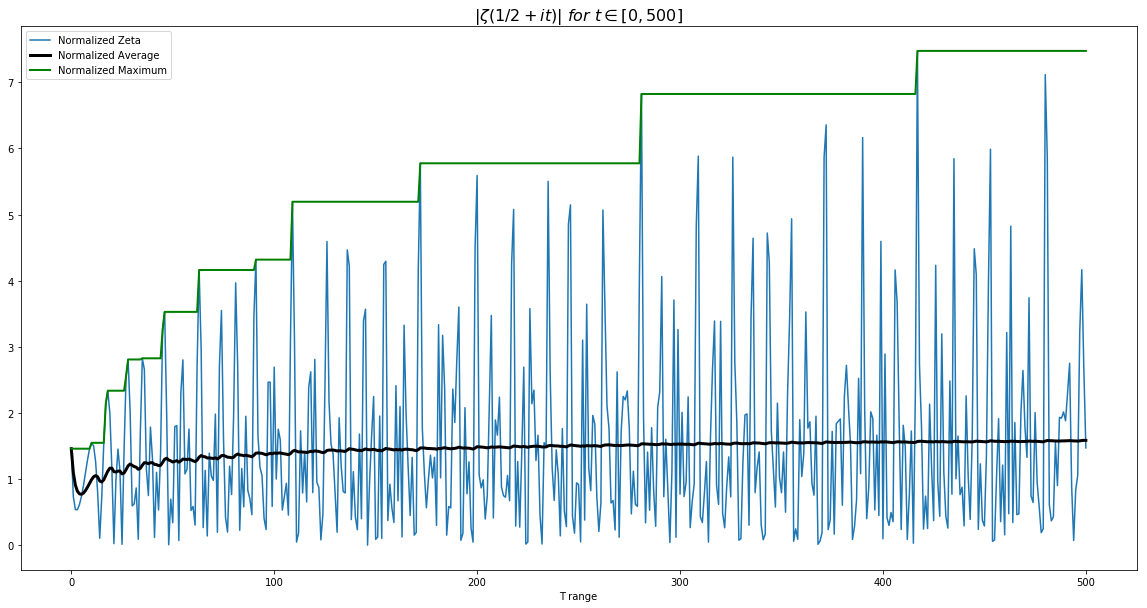

In [7]:
plt.figure(figsize=(20,10))  
plt.title('$|\zeta(1/2 + it)| \ for \ t\in [{},{}]$'.format(N, N+deltaN), size=16)
plt.plot(t_range, norm_zeta_value, label='Normalized Zeta')
plt.plot(t_range, average, label='Normalized Average', lw=3, color='black')
plt.plot(t_range, maximum, label='Normalized Maximum', lw=2, color='green')
plt.xlabel('T range')
plt.legend()
plt.show()

### A model for large values of $log(\zeta)$

Our Zeta Stochastic Function is defined $(\ X_T(h),\  h\in I)$, with $I\in [-1,1]$
$$X_T(h) = \sum_{p\leq T}\cdot \frac{1}{\sqrt{p}}Re(p^{ih}e^{i\theta_p})$$
Where $p$ refers to the primes, $Re$ is concerned with the 'real' part of the expression $p^{ih}e^{i\theta_p}$ and $\theta_p \sim U(0,2\pi) \ IID$ and indexed by primes

Through Euler's method we have the following realization
$$X_T(h) = \sum_{p\leq T}\cdot \frac{1}{\sqrt{p}}cos(\theta_p - hlog(p))$$

In [3]:
# Reading in a Prime list

try:
    # ideally prime numbers should be calculated externally or stored in a txt file
    print('File found, returning prime list...')
    text_file = open("prime.txt", "r")
    prime_num = np.array(list(map(lambda x: int(x), text_file.read().split(',')[:-1])))
    print("Primes returned up to", prime_num[-1])
    
except FileNotFoundError:
    print('File not found, generating prime list...')
    
    # Stores prime list up to 10^8 (ideally should hold 10^50)
    prime_num = np.array(list(pyprimes.primes_below(1e8)))
    
    # store the prime number list in a text file (temporary)
    f = open("prime.txt", "w")
    for i in prime_num:
        f.write("{},".format(str(i)))
    f.close()
    
    text_file = open("prime.txt", "r")
    prime_num = np.array(list(map(lambda x: int(x), text_file.read().split(',')[:-1])))
    print("Primes returned up to", prime_num[-1])

File found, returning prime list...
Primes returned up to 99999989


In [4]:
%%cython
cimport numpy as nc
from libc.math cimport log, sqrt, pi, cos

import pyximport
pyximport.install(pyimport=True)

from random import uniform

# Model is developed above 
def zetaStochastic(double h, int T, nc.ndarray prime_list) -> double:
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param h: Provide a floating interval range to observe the Zeta function
    :param T: Provide an integer number to cap off the consecutive sum of primes
    :param prime list: Provide an array of prime numbers
    :return: Returns a value for the stochastic Zeta function 
    """
    assert T < int(1e10), 'Our prime list does not exceed the value 10^7'
    
    cdef double ret_val = 0.0
    cdef int p = 0
    
    # filter the primes up to and including the value of T
    cdef nc.ndarray primes = prime_list[prime_list <= T]
    
    # itterate through the primes using the specified model 
    for p in primes: 
        ret_val += 1/sqrt(p) * cos(uniform(0, 2*pi) - h*log(p)) 
        
    return ret_val

In [5]:
# value of T placed at 10^7 (ideally taken should be taken 10^15, 10^25, etc)
T_val = int(1e6)

# create range interval of h from -1 to 1 (points at every 1/log(T))
x=np.arange(-1,1,1/np.round(np.log(T_val)))

In [6]:
x

array([-1.00000000e+00, -9.28571429e-01, -8.57142857e-01, -7.85714286e-01,
       -7.14285714e-01, -6.42857143e-01, -5.71428571e-01, -5.00000000e-01,
       -4.28571429e-01, -3.57142857e-01, -2.85714286e-01, -2.14285714e-01,
       -1.42857143e-01, -7.14285714e-02, -4.44089210e-16,  7.14285714e-02,
        1.42857143e-01,  2.14285714e-01,  2.85714286e-01,  3.57142857e-01,
        4.28571429e-01,  5.00000000e-01,  5.71428571e-01,  6.42857143e-01,
        7.14285714e-01,  7.85714286e-01,  8.57142857e-01,  9.28571429e-01])

In [7]:
# run time complexity of the stochastic zeta function
run_time = np.arange(1, 20, 2)
complexity = []

for s in run_time:
    t1 = time()
    [[zetaStochastic(h=i, T=T_val, prime_list=prime_num) for i in x] for _ in range(s)]
    complexity.append(time() - t1)

In [8]:
# preform regression on the runtime of the stochastic zeta function
comp_reg_slope = linregress(run_time, complexity).slope 
comp_reg_intercept = linregress(run_time, complexity).intercept 

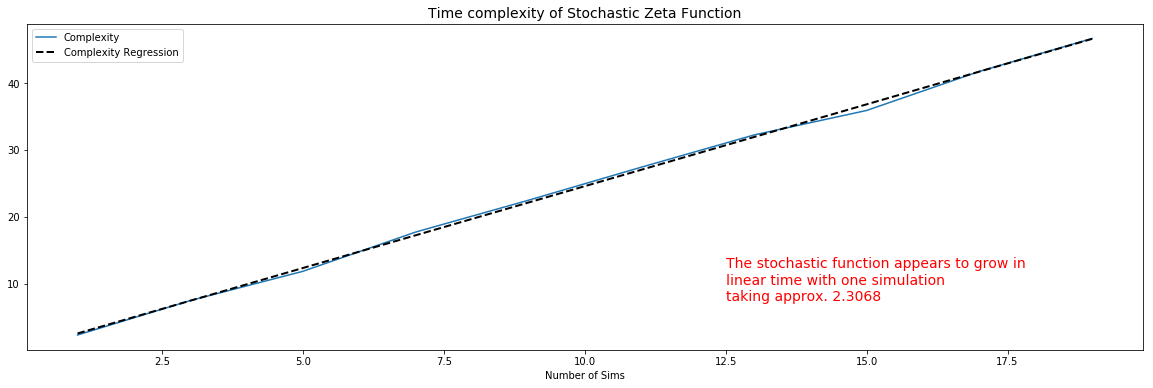

In [9]:
plt.figure(figsize=(20,6))  
plt.title("Time complexity of Stochastic Zeta Function", size=14)
plt.plot(run_time, complexity, label='Complexity')
plt.plot(run_time, [comp_reg_slope*i + comp_reg_intercept for i in range(1,20, 2)], label='Complexity Regression', 
         ls='--', lw=2, color='black')
plt.text(12.5, 7.5, 
         'The stochastic function appears to grow in \nlinear time with one simulation\ntaking approx. {}'.format(round(complexity[0], 4)), 
         size=14, color='red')
plt.xlabel('Number of Sims')
plt.legend()
plt.show()

In [15]:
# create stochastic zeta range over h interval 
sims = 100
y = np.array([[zetaStochastic(h=i, T=T_val, prime_list=prime_num) for i in x] for _ in range(sims)]).reshape(sims, x.size)

In [16]:
y

array([[ 0.26359461,  0.71801085,  0.19394777, ..., -0.02815996,
         0.3608862 ,  1.17998303],
       [ 0.55058548, -1.07781303, -0.05298209, ..., -1.39738939,
        -0.98562611, -0.04856212],
       [ 2.57199963,  1.82954568,  1.6732636 , ...,  1.03478426,
        -0.58532137,  1.17001801],
       ...,
       [ 1.68033186,  0.76279138, -0.94013556, ...,  1.94482927,
        -2.21363618, -1.54439813],
       [-0.3627038 , -0.92581276, -0.524226  , ...,  1.68206079,
         0.54499973,  0.22559485],
       [ 2.14515454,  0.41960611, -1.68973883, ..., -1.8761237 ,
        -1.93847934,  0.35890379]])

In [17]:
# rolling maximum of norm function
# maximum = [y[:, :i+1].max() for i in range(y.shape[1])]

# rolling minimum of norm function
# minimum = [y[:, :i+1].min() for i in range(y.shape[1])]

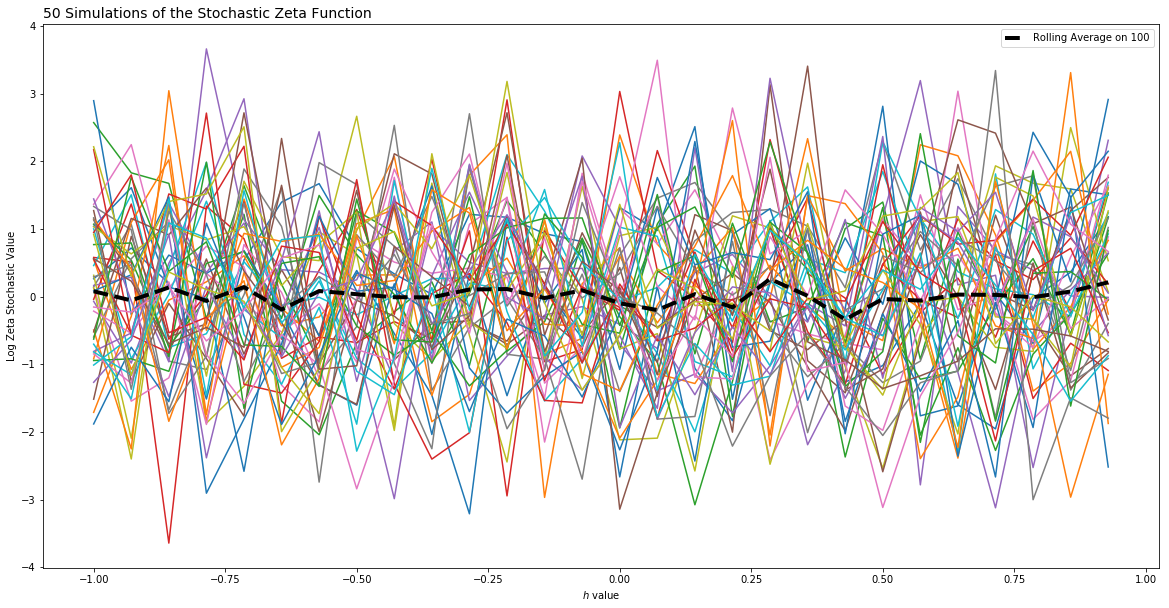

In [18]:
plt.figure(figsize=(20,10))  
plt.title("50 Simulations of the Stochastic Zeta Function", loc='left', size=14)
for i in y[:50]:
    plt.plot(x, i)
plt.plot(x, np.average(y, axis=0), lw=4, color='black', label='Rolling Average on {}'.format(sims), ls='--')
# plt.plot(x, maximum, lw=2, color='red', ls='--', label='Rolling Maximum')
# plt.plot(x, minimum, lw=2, color='red', ls='--', label='Rolling Minimum')

plt.ylabel('Log Zeta Stochastic Value')
plt.xlabel('$h$ value')
plt.legend()
plt.show()

**Conjecture**

We assert that the maxium of the stochastic function should be defined as follows:
$$max_{|h|<1}X_t(h)\approx log(log(T)) - \frac{3}{4}log(log(log(T)))$$
Abbreviating the log expressions, we underscore each log with the number of succesive logs taken of the value $T$ below
$$max_{|h|<1}X_t(h)\approx log_2(T)) - \frac{3}{4}log_3(T)))$$

In [19]:
# computes the max of the stochastic zeta function 
max_function = lambda x: (np.log(np.log(x)) - 0.75*np.log(np.log(np.log(x))))

In [20]:
cong_max = max_function(T_val)
print("Our simulated maximum was    ->", np.average(y.max(axis=1)))
print("Conjecture maximum should be ->", cong_max)

Our simulated maximum was    -> 2.368072664469283
Conjecture maximum should be -> 1.901755015287042


**Function Variation**

To measure the degree of variation expected with the simulation for large values of Zeta, we need to consider extreme statistics for determining the extent of our model's variation. We begin by recentering our stochastic model as follows: 
$$\Theta = max_{|h|<1}X_t(h) - (log_2(T) - \frac{3}{4}log_3(T))$$
We say that our $\Theta$ follows a [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution), defined below
$$P(\Theta < x)=exp(-e^\frac{-(x-\mu)}{\beta})$$ 
$$P(\Theta < x)=exp(-ce^{-2x}) \, \ \ \  \mu = 0 \ , \ \ \beta = \frac{1}{2}$$ 

Our variance measure is then:
$$Var(\Theta)=\frac{\pi^2}{6}\beta^2=\frac{\pi^2}{24}$$

Hence, in our case our expression for the maximum of our stochastic process introduces and error term: 
$$log_2(T) - \frac{3}{4}log_3(T) + (Gumbel)$$

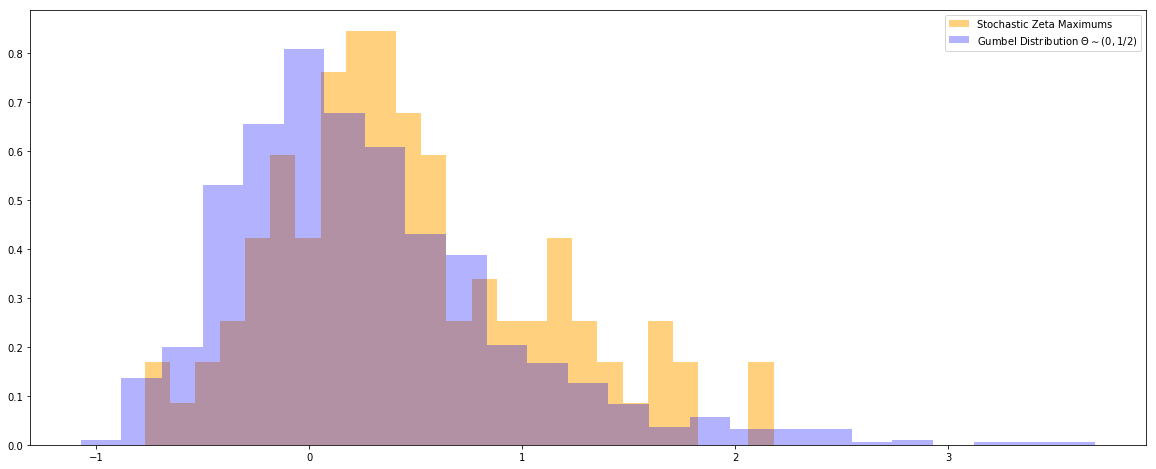

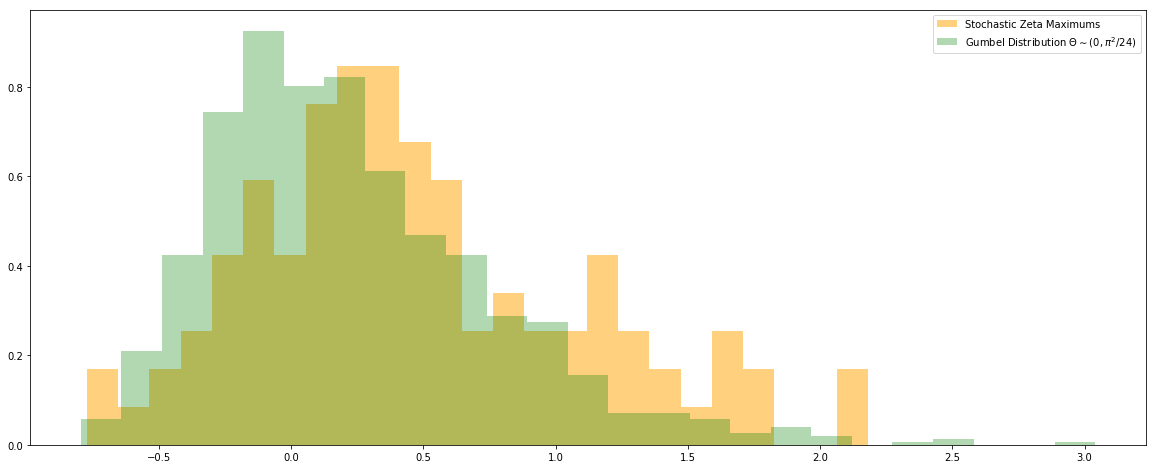

In [21]:
bins = 25
error = (y.max(axis=1)-cong_max)

# re-centered Gumbel distrubtion to observe the shape of the hist (variance 1/2)
plt.figure(figsize=(20, 8))
plt.hist(error, bins=bins, alpha=0.5, color='orange', density=True, 
         label="Stochastic Zeta Maximums") 
plt.hist(gumbel_r.rvs(loc=0, scale=0.5, size=1000), bins=bins, alpha=0.3, color='blue', 
         label="Gumbel Distribution $\Theta \sim (0,1/2)$", density=True)
plt.legend()
plt.show()

# re-centered normal distrubtion to observe the shape of the hist (variance pi^2/24)
plt.figure(figsize=(20, 8))
plt.hist(error, bins=bins, alpha=0.5, color='orange', density=True, 
         label="Stochastic Zeta Maximums")
plt.hist(gumbel_r.rvs(loc=0, scale=(np.pi**2)/24, size=1000), bins=bins, alpha=0.3, color='green', 
         label="Gumbel Distribution $\Theta \sim (0,\pi^2/24)$", density=True)
plt.legend()
plt.show()

Analyzing the distribution of model error, defined as our approximated model maximum minus our theoretical value  
$$\hat{max}_{|h|<1}X_t(h) - max_{|h|<1}X_t(h)$$
We see that the error measure doesn't quite follow the outline of a Gumbel distribution with variance $\frac{\pi^2}{24}$, for small values of $T$ (e.g. $10^6$) having intervals of sustained error exceeding a difference of 1. This issue might be rectified, however, as $T\rightarrow \infty$, we explore this below.   

In [22]:
time_range = [int(1e3), 5000, int(1e4), 50000, int(1e5), 500000, int(1e6), 5000000, int(1e7)]

In [23]:
error_arr = []

# examine the error decay from projected to theoretical as T grows 
for t in time_range:
    temp_arr = np.array([[zetaStochastic(h=i, T=t, prime_list=prime_num) for i in x] for _ in range(2)])
    
    # compute the error term for the given value of T
    e_term = np.average(y.max(axis=1)) - max_function(t)
    error_arr.append(e_term)

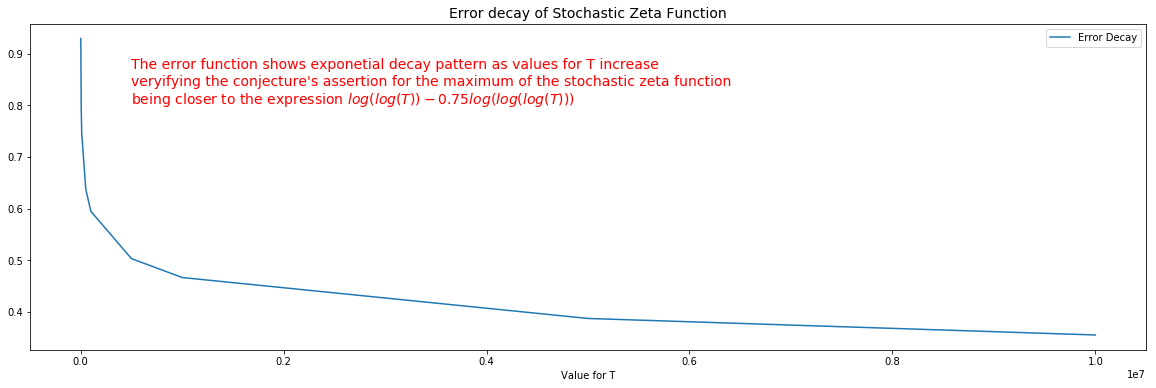

In [24]:
plt.figure(figsize=(20,6))  
plt.title("Error decay of Stochastic Zeta Function", size=14)
plt.plot(time_range, error_arr, label='Error Decay')
plt.text(500000, 0.8, 
         "The error function shows exponetial decay pattern as values for T increase\nveryifying the conjecture's assertion for the maximum of the stochastic zeta function\nbeing closer to the expression $log(log(T)) - 0.75log(log(log(T)))$ ", 
         size=14, color='red')
plt.xlabel('Value for T')
plt.legend()
plt.show()

### Fyodorov-Hiary-Keating Conjecture

**Conjecture (Fyodorov-Hiary-Keating '12)'**

if $\tau\sim Unif(T,2T)$, then as $T \rightarrow \infty$
$$max_{|h|<1}|\zeta(1/2 + i(\tau +h))| = \frac{log(T)}{log(log(T))^{3/4}}$$
Using the same log convention discussed earlier we have 
$$max_{|h|<1}|\zeta(1/2 + i(\tau +h))| = \frac{log(T)}{log_2(T))^{3/4}}$$

In [10]:
%%cython
cimport numpy as nc

import pyximport
pyximport.install(pyimport=True)

from mpmath import zeta
from random import uniform

def zetaUniformNorm(int T, int h) -> double:
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param N: Provide a number (presumably large) to start computing values for
    :param deltaN: Provide an integer number to cap off the consecutive sums of prime
    :return: Returns an array of the normalized values for Zeta 
    """
    cdef nc.complex128_t point = complex(0, 0)

    # computing the Zeta function for a single point h for a given T
    point = zeta(complex(real=0.5, imag=uniform(T, 2*T) + h))

    return abs(point)

In [11]:
# value of T placed at 10^7 (ideally taken should be taken 10^15, 10^25, etc)
T_uniform = int(1e6)

# create range interval of h from -1 to 1 (points at every 1/log(T))
x_uniform=np.arange(-1,1,1/np.round(np.log(T_val)))

In [12]:
uniform_sims = 100

In [13]:
uniform_zeta = np.array([[zetaUniformNorm(T=100, h=H) for H in x_uniform] for _ in range(uniform_sims)])

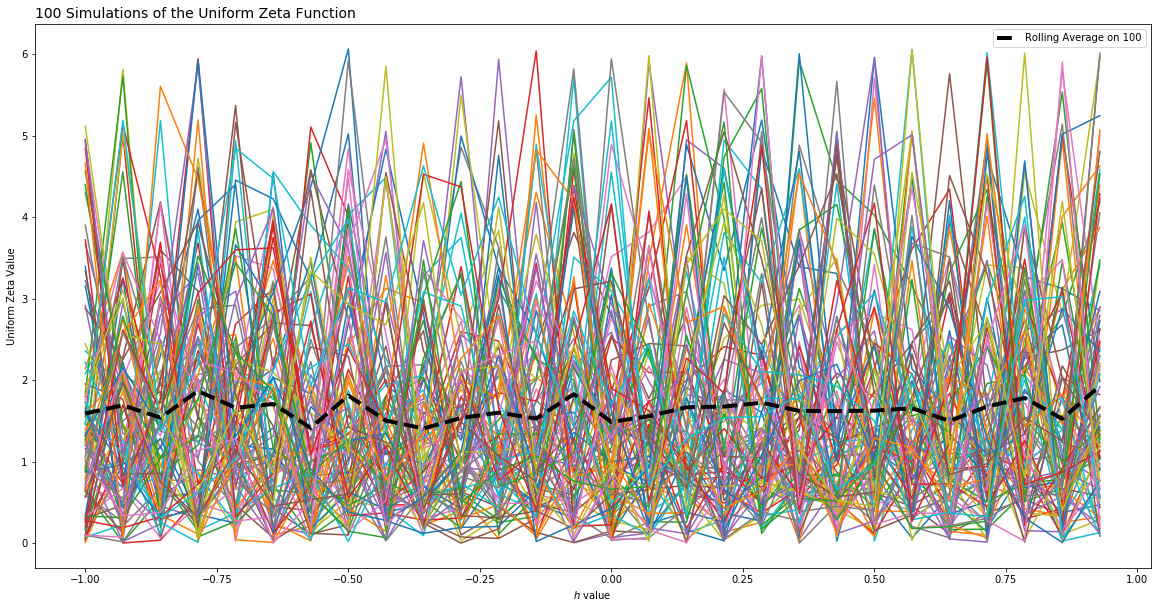

In [15]:
plt.figure(figsize=(20,10))  
plt.title("{} Simulations of the Uniform Zeta Function".format(uniform_sims), loc='left', size=14)
for i in uniform_zeta:
    plt.plot(x_uniform, i)
plt.plot(x_uniform, np.average(uniform_zeta, axis=0), lw=4, color='black', label='Rolling Average on {}'.format(uniform_sims), ls='--')

plt.ylabel('Uniform Zeta Value')
plt.xlabel('$h$ value')
plt.legend()
plt.show()

In [19]:
# computes the max of the stochastic zeta function 
uniform_max_func = lambda x: (np.log(x) /  (np.log(np.log(x))**0.75))

In [20]:
cong_max = uniform_max_func(T_uniform)
print("Our simulated maximum was    ->", np.average(uniform_zeta.max(axis=1)))
print("Conjecture maximum should be ->", cong_max)

Our simulated maximum was    -> 5.153104551279773
Conjecture maximum should be -> 6.6976385917995795
